In [158]:
"""
Atividade para trabalhar o pré-processamento dos dados.
Criação de modelo preditivo para diabetes e envio para verificação de peformance
no servidor.
@author: Aydano Machado <aydano.machado@gmail.com>
"""

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import requests

import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer

In [159]:
print('\n - Lendo o arquivo com o dataset sobre diabetes')
data = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_dataset.csv')

data


 - Lendo o arquivo com o dataset sobre diabetes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
4,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
567,9,89.0,62.0,NaN,NaN,22.5,0.142,33,0
568,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
569,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
570,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


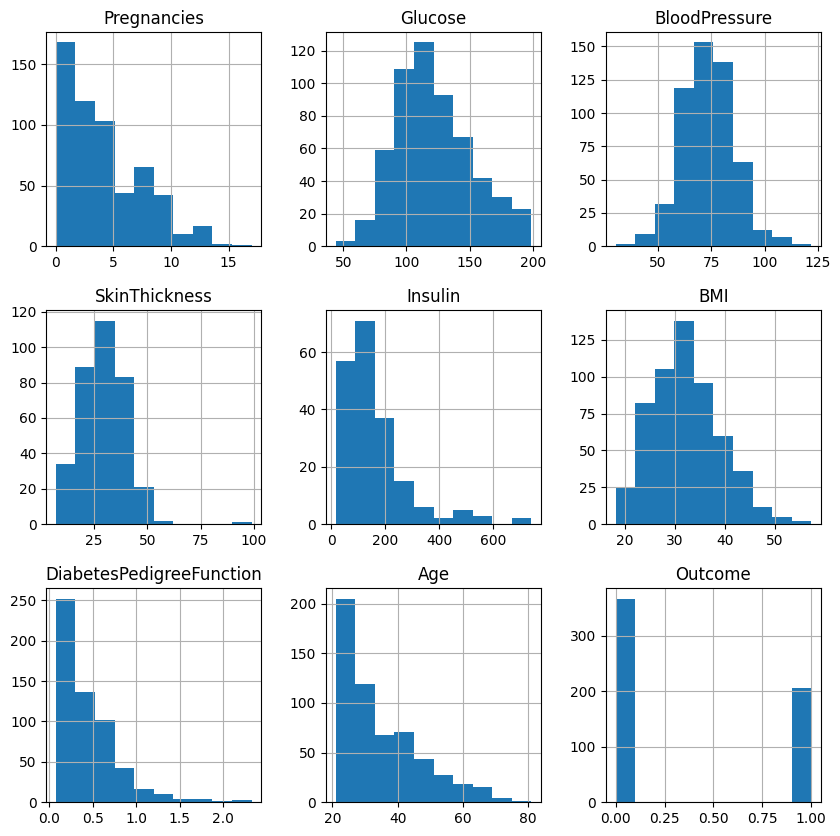

In [160]:
data.hist(figsize = (10, 10))
plt.show()

In [66]:
# Checando colunas com dados faltantes
for column in data.columns:
    print(f'###  {column}  ###')

    print(f"NaN: {data[column].isna().sum()}")
    print('')

###  Pregnancies  ###
NaN: 0

###  Glucose  ###
NaN: 5

###  BloodPressure  ###
NaN: 35

###  SkinThickness  ###
NaN: 227

###  Insulin  ###
NaN: 374

###  BMI  ###
NaN: 11

###  DiabetesPedigreeFunction  ###
NaN: 0

###  Age  ###
NaN: 0

###  Outcome  ###
NaN: 0



In [161]:
# Criando X and y par ao algorítmo de aprendizagem de máquina.\
print(' - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset')

def fill_nan(df):
    # Preenchimento com a mediana
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')

    #df = df[feature_cols]
    idf = pd.DataFrame(imputer.fit_transform(df))
    idf.columns = df.columns
    idf.index = df.index

    return idf


def fill_nan_by_class(df):
    # Separar entre saudáveis e diabéticos para adicionar o valores faltantes
    df_healthy = df[df['Outcome']==0].copy()
    df_sick = df[df['Outcome']==1].copy()

    # Preencher dados faltantes usando a mediana da classe
    for column in df_healthy.columns[:-1]:
        df_healthy[column].fillna(df_healthy[column].median(), inplace=True)

    for column in df_sick.columns[:-1]:
        df_sick[column].fillna(df_sick[column].median(), inplace=True)

    df_all = pd.concat([df_healthy, df_sick])

    return df_all


def remove_nan(df, cols_to_drop_na):

    df = df.dropna(subset=cols_to_drop_na)

    return df


# Caso queira modificar as colunas consideradas basta algera o array a seguir.
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'SkinThickness', 'Insulin']
cols = [*feature_cols, 'Outcome']

new_data = data[cols]
new_data = remove_nan(new_data, ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'SkinThickness', 'Insulin'])
#new_data = fill_nan(new_data)
#new_data = fill_nan_by_class(new_data)


X = new_data[feature_cols]
y = new_data['Outcome']

X

 - Criando X e y para o algoritmo de aprendizagem a partir do arquivo diabetes_dataset


,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,SkinThickness,Insulin
3,0,137.0,40.0,43.1,2.288,33,35.0,168.0
6,2,197.0,70.0,30.5,0.158,53,45.0,543.0
12,0,118.0,84.0,45.8,0.551,31,47.0,230.0
14,1,103.0,30.0,43.3,0.183,33,38.0,83.0
15,3,126.0,88.0,39.3,0.704,27,41.0,235.0
...,...,...,...,...,...,...,...,...
553,13,153.0,88.0,40.6,1.174,39,37.0,140.0
554,12,100.0,84.0,30.0,0.488,46,33.0,105.0
558,1,121.0,78.0,39.0,0.261,28,39.0,74.0
565,2,88.0,58.0,28.4,0.766,22,26.0,16.0


## Feature Selection
Based on:
- https://datascience.stackexchange.com/questions/42121/features-selection-in-knn
- https://www.naukri.com/learning/articles/feature-selection-techniques-python-code/

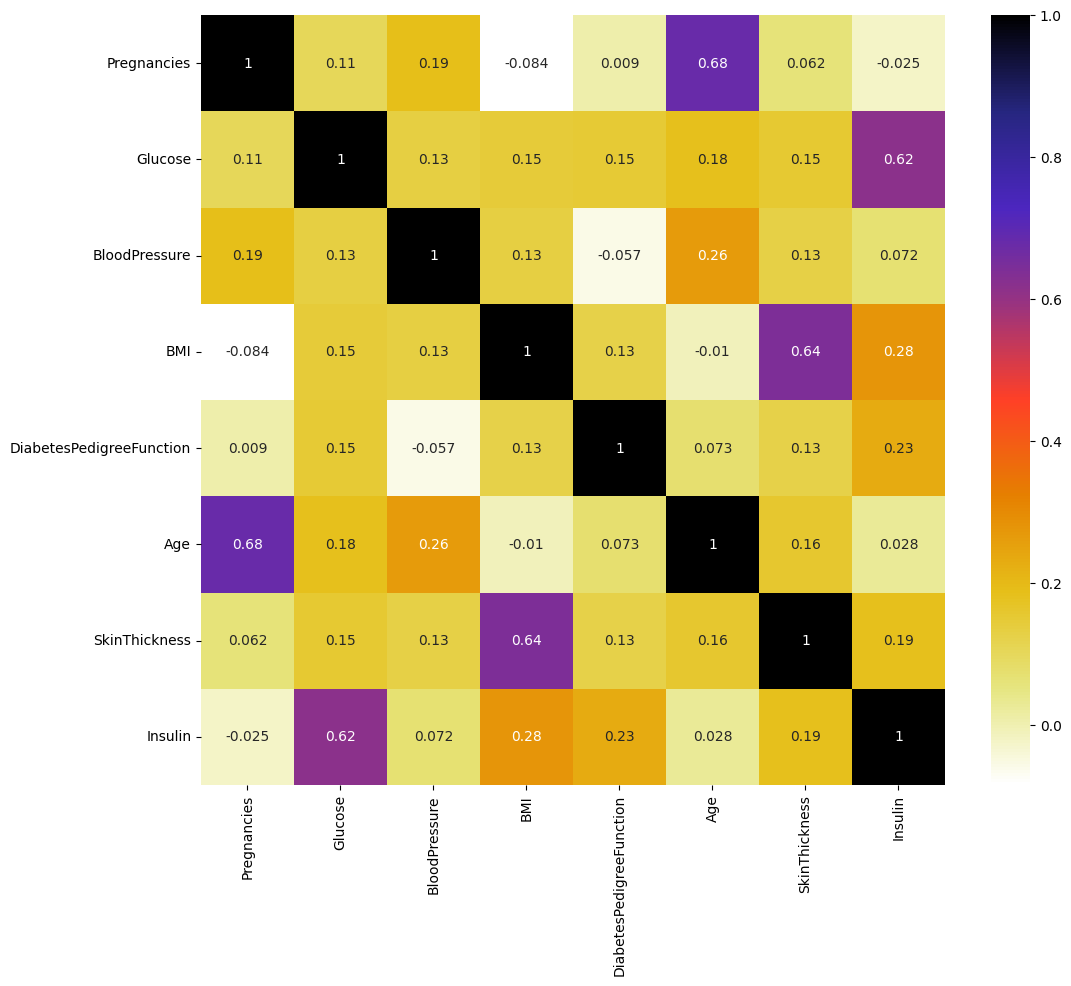

In [162]:
#Using Pearson Correlation
import seaborn as sns

cor = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show() 

In [163]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]                  
                col_corr.add(colname)
    return col_corr   

corr_features = correlation(X, 0.6)
corr_features

{'Age', 'Insulin', 'SkinThickness'}

In [164]:
# Exlui colunas que são correlacionadas com outras
X = X.drop(corr_features,axis=1)

X

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction
3,0,137.0,40.0,43.1,2.288
6,2,197.0,70.0,30.5,0.158
12,0,118.0,84.0,45.8,0.551
14,1,103.0,30.0,43.3,0.183
15,3,126.0,88.0,39.3,0.704
...,...,...,...,...,...
553,13,153.0,88.0,40.6,1.174
554,12,100.0,84.0,30.0,0.488
558,1,121.0,78.0,39.0,0.261
565,2,88.0,58.0,28.4,0.766


In [180]:
from sklearn.feature_selection import mutual_info_classif

# Determina a informação mútua (importância da feature em relação ao Outcome)
mutual_info = mutual_info_classif(X, y)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
#mutual_info = mutual_info.sort_values(ascending=False)

mutual_info

Pregnancies                 0.035873
Glucose                     0.168597
BloodPressure               0.030328
BMI                         0.060959
DiabetesPedigreeFunction    0.000000
dtype: float64

In [181]:
# Usa o valor da informação mútua para criar pesos para as features (já que o KNN é burro)
weights = mutual_info*100.0
weights

Pregnancies                  3.587300
Glucose                     16.859746
BloodPressure                3.032834
BMI                          6.095911
DiabetesPedigreeFunction     0.000000
dtype: float64

In [182]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Normalizando os dados

X_temp = X.copy()
X_temp['Class'] = -1

normalize = PowerTransformer().fit(X)
normalize = StandardScaler().fit(X)

X_norm = pd.DataFrame(normalize.transform(X), columns = X.columns)
X_norm = X_norm.round(2)

X_norm

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction
0,-1.04,0.45,-2.44,1.48,4.69
1,-0.45,2.46,-0.08,-0.43,-1.02
2,-1.04,-0.18,1.03,1.89,0.04
3,-0.75,-0.68,-3.23,1.51,-0.95
4,-0.15,0.09,1.34,0.91,0.45
...,...,...,...,...,...
191,2.80,0.99,1.34,1.10,1.71
192,2.51,-0.78,1.03,-0.51,-0.13
193,-0.75,-0.08,0.55,0.86,-0.74
194,-0.45,-1.18,-1.02,-0.75,0.61


## Normalizando os dados

In [183]:
# Normalizando os dados de teste

data_app = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_app.csv')

data_app = data_app[feature_cols]

# Exclui fearures correlacionadas também
data_app = data_app.drop(corr_features,axis=1)

data_app_norm = pd.DataFrame(normalize.transform(data_app), columns = data_app.columns)
data_app_norm = data_app_norm.round(2)

data_app_norm 

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction
0,-0.15,0.19,-0.55,-1.06,-0.85
1,-0.15,2.26,-0.23,-0.37,-0.64
2,3.39,0.42,-0.08,0.57,-1.03
3,-0.75,-0.48,-0.86,-1.21,1.10
4,1.32,0.92,0.55,1.45,-0.06
...,...,...,...,...,...
191,-0.15,1.89,-0.55,0.10,-0.71
192,-0.15,-0.82,-1.34,-1.18,-1.03
193,1.32,1.76,1.50,0.05,-0.19
194,-1.04,-1.32,0.87,0.74,-0.81


In [91]:
# Estratégia pra usar PCA
# from sklearn.decomposition import PCA # Make an instance of the Model

# pca = PCA(n_components=3)

# pca.fit(X_norm)

# X_norm_pca = pca.transform(X_norm)
# data_app_norm_pca = pca.transform(data_app_norm)

In [185]:
# Aplica os pesos
X_norm_w = X_norm * weights
data_app_norm_w = data_app_norm * weights 

X_norm_w

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction
0,-3.730792,7.586886,-7.400115,9.021948,0.0
1,-1.614285,41.474975,-0.242627,-2.621242,-0.0
2,-3.730792,-3.034754,3.123819,11.521272,0.0
3,-2.690475,-11.464627,-9.796053,9.204826,-0.0
4,-0.538095,1.517377,4.063997,5.547279,0.0
...,...,...,...,...,...
191,10.044441,16.691149,4.063997,6.705502,0.0
192,9.004124,-13.150602,3.123819,-3.108915,-0.0
193,-2.690475,-1.348780,1.668059,5.242483,-0.0
194,-1.614285,-19.894500,-3.093491,-4.571933,0.0


In [186]:
# Ciando o modelo preditivo para a base trabalhada
print(' - Criando modelo preditivo')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_norm_w, y)

 - Criando modelo preditivo


KNeighborsClassifier(n_neighbors=3)

In [187]:
#realizando previsões com o arquivo de
print(' - Aplicando modelo e enviando para o servidor')
#data_app = pd.read_csv('https://raw.githubusercontent.com/aydanomachado/mlclass/master/01_Preprocessing/diabetes_app.csv')
#data_app = data_app[feature_cols]

y_pred = neigh.predict(data_app_norm_w)

# Enviando previsões realizadas com o modelo para o servidor
URL = "https://aydanomachado.com/mlclass/01_Preprocessing.php"

#TODO Substituir pela sua chave aqui
DEV_KEY = "720pster"

# json para ser enviado para o servidor
data_json = {'dev_key':DEV_KEY,
             'predictions':pd.Series(y_pred).to_json(orient='values')}

 - Aplicando modelo e enviando para o servidor


In [190]:
# Enviando requisição e salvando o objeto resposta
r = requests.post(url = URL, data = data_json)

# Extraindo e imprimindo o texto da resposta
pastebin_url = r.text
print(" - Resposta do servidor:\n", r.text, "\n")

 - Resposta do servidor:
 {"status":"success","dev_key":"720pster","accuracy":0.6275510204081632,"old_accuracy":0.65816326530612} 

